<a href="https://colab.research.google.com/github/Mithun162001/Final-Year-Project/blob/main/Final_Year_Projcet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <CENTER><U>**FINAL YEAR PROJECT - 2022**</U></CENTER>

<CENTER><h3><B>DEEP IMAGE INPAINTING USING AUTO-ENCODERS</B></CENTER>

<b>Team members:</b>
* 19BTRCR007 - Myil Vaughanan V L (C)
* 19BTRCR039 - Varshini D         
* 19BTRCR016 - Sunaina Naikodi
* 19BTRCR006 - Mithun G


<b>Title of the project:</b>
* Deep Image Inpainting using Auto-Encoders

<b>Objective of the project:</b>
* To rebuild or restore the missing or damaged pixels of the image to bring it back to life as good as ever using autoencoders method.

<b>Requirements:</b>
* Tensorflow 2.x
* Python 3
* Google Colab
* scikit-learn
* numpy, pandas, matplotlib, os modules

<b>Github Link:</b>
* https://github.com/Mithun162001/Final-Year-Project

**importing the necessary modules**

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tensorflow as tf
from tensorflow import keras
import cv2

%matplotlib inline

**Checking the available resources**

In [43]:
# to check the GPU resources
!nvidia-smi

Sun Oct 30 09:50:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
# checking the CPU model
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [45]:
# to check the allocated memory:
!free -h --si | awk  '/Mem:/{print $2}'

13G


In [46]:
# to check the version of tensorflow running

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.9.2


**import the dataset - CIFAR 10**

This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories.

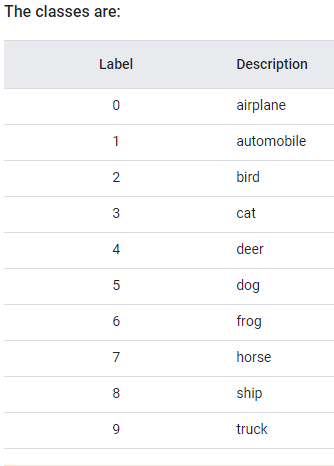

In [47]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [48]:
print("Shape of the training data:", X_train.shape)
print("Shape of the testing data:", X_test.shape)
print("Shape of each image: ", X_train[0].shape)

Shape of the training data: (50000, 32, 32, 3)
Shape of the testing data: (10000, 32, 32, 3)
Shape of each image:  (32, 32, 3)


**Data pre-processing**

In [49]:
# one-hot encoding

from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train, num_classes=10)
y_cat_test = to_categorical(y_test, num_classes=10)

In [50]:
y_train[0]

array([6], dtype=uint8)

In [51]:
y_cat_train[0]     # one-hot encoded

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

**Visualization of CIFAR-10 dataset**

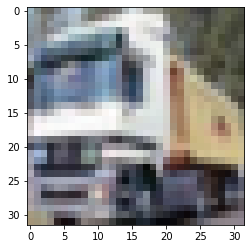

In [52]:
# display one of the image

plt.imshow(X_train[1])

In [53]:
y_train[1]    # labelled as truck - 9

array([9], dtype=uint8)

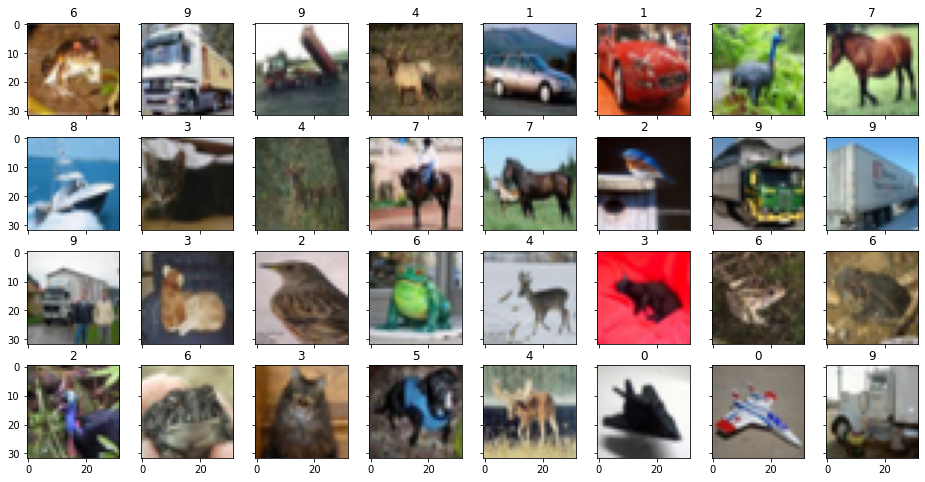

In [54]:
from mpl_toolkits.axes_grid1 import ImageGrid
sample_images = X_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

**Data Generator with augumentation**

In [55]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

      x = y = np.random.randint(0, 31, 1)[0]
      w = h = np.random.randint(1, 10, 1)[0]

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        mask = np.full(tmp_image.shape, 255, np.uint8)
        mask[y:y+h,x:x+w] = 0
        res = cv2.bitwise_and(tmp_image, mask)
        X_batch[i,] = res/255
        y_batch[i] = self.y[idx]/255
        
      return X_batch, y_batch

In [56]:
traingen = createAugment(X_train, X_train)
testgen = createAugment(X_test, X_test)

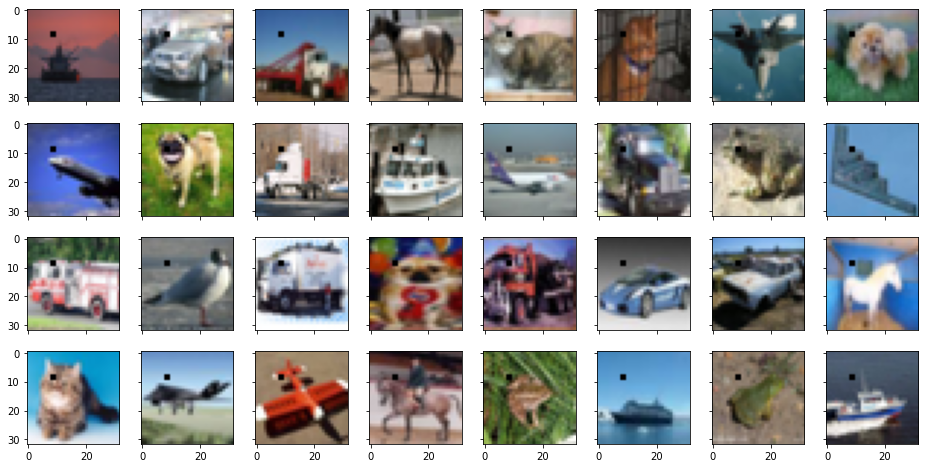

In [57]:
sample_idx = 99 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()